In [1]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle
import shap
import matplotlib.pyplot as plt
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [2]:
lgbm_tuned = {
    "learning_rate" : 0.10090558417844547, 
    "max_depth" : 7, 
    "n_estimators" : 289
}
# lgbm_tuned += LIGHTGBM_PARAMS

xgb_tuned = {
    "learning_rate" : 0.10258423586932192, 
    "max_depth" : 3, 
    "n_estimators" : 212
}
# xgb_tuned += XGBOOST_PARAMS

# tabnet_tuned = {
#     "gamma" : 1.0, 
#     "lambda_sparse" : 0.001, 
#     "n_steps" : 3,
#     "n_a" : 8,
# }

tabnet_tuned = {
    "gamma" : 1.1, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 6,
    "n_a" : 32,
}
tabnet_tuned["n_d"] = tabnet_tuned["n_a"]

tabnet_paper = {
    "gamma" : 1.2, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 7,
    "n_a" : 32,
    "momentum" : 0.9,
    "optimizer_params" : dict(lr=1e-2)
}
tabnet_paper["n_d"] = tabnet_paper["n_a"]

xgb_paper = {
    "max_depth" : 6, 
}

lgbm_paper = {
    "num_leaves" : 64,
}

In [3]:
train = pd.read_csv("data/kdd/small/churn/train.csv")
valid = pd.read_csv("data/kdd/small/churn/val.csv")
test = pd.read_csv("data/kdd/small/churn/test.csv")

In [4]:
categorical_idx = list(range(190, train.shape[1] - 1))

categorical_dims = [len(set(list(train.iloc[:, x].unique()) + list(valid.iloc[:, x].unique()) + list(test.iloc[:, x].unique()))) for x in categorical_idx]

In [5]:
for idx in range(0, len(categorical_dims)):
    if categorical_dims[idx] > 1:
        train.iloc[:, categorical_idx[idx]] = [int(x) for x in train.iloc[:, categorical_idx[idx]]]
        valid.iloc[:, categorical_idx[idx]] = [int(x) for x in valid.iloc[:, categorical_idx[idx]]]
        test.iloc[:, categorical_idx[idx]] = [int(x) for x in test.iloc[:, categorical_idx[idx]]]
    else:
        train.iloc[:, categorical_idx[idx]] = [0] * train.shape[0]
        valid.iloc[:, categorical_idx[idx]] = [0] * valid.shape[0]
        test.iloc[:, categorical_idx[idx]] = [0] * test.shape[0]

In [6]:
train = pd.concat([train, valid])

In [7]:
train_X = train.drop(["TARGET"], axis=1)
train_y = train["TARGET"]

test_X = test.drop(["TARGET"], axis=1)
test_y = test["TARGET"]

In [8]:
model_lgbm = LGBMClassifier(**{**lgbm_tuned, **LIGHTGBM_PARAMS})
model_lgbm.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

Using categorical_feature in Dataset.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(learning_rate=0.10090558417844547, max_depth=7, metric='auc',
               n_estimators=289, objective='binary', random_state=42)

In [9]:
model_lgbm_paper = LGBMClassifier(**{**lgbm_paper, **LIGHTGBM_PARAMS})
model_lgbm_paper.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

LGBMClassifier(metric='auc', num_leaves=64, objective='binary', random_state=42)

In [10]:
model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
model_xgb.fit(train_X, train_y, verbose=1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[07:35:50] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:35:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.10258423586932192, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=212, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [11]:
model_xgb_paper = XGBClassifier(**{**xgb_paper, **XGBOOST_PARAMS})
model_xgb_paper.fit(train_X, train_y, verbose=1)

[07:35:59] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:35:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [12]:
TABNET_PARAMS["verbose"] = 1

In [13]:
model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet.fit(train_X.values, train_y.values, max_epochs=50)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.73658 |  0:00:35s
epoch 1  | loss: 0.28078 |  0:01:10s
epoch 2  | loss: 0.27477 |  0:01:44s
epoch 3  | loss: 0.26976 |  0:02:19s
epoch 4  | loss: 0.26492 |  0:02:54s
epoch 5  | loss: 0.26272 |  0:03:28s
epoch 6  | loss: 0.26282 |  0:04:02s
epoch 7  | loss: 0.26292 |  0:04:36s
epoch 8  | loss: 0.26194 |  0:05:15s
epoch 9  | loss: 0.26227 |  0:05:52s
epoch 10 | loss: 0.26307 |  0:06:29s
epoch 11 | loss: 0.26059 |  0:07:13s
epoch 12 | loss: 0.25908 |  0:07:50s
epoch 13 | loss: 0.25709 |  0:08:29s
epoch 14 | loss: 0.25612 |  0:09:15s
epoch 18 | loss: 0.2325  |  0:12:18s
epoch 19 | loss: 0.21481 |  0:12:54s
epoch 20 | loss: 0.19443 |  0:13:27s
epoch 21 | loss: 0.17216 |  0:14:01s
epoch 22 | loss: 0.15675 |  0:14:34s
epoch 23 | loss: 0.14157 |  0:15:08s
epoch 24 | loss: 0.12958 |  0:15:42s
epoch 25 | loss: 0.11973 |  0:16:15s
epoch 26 | loss: 0.11227 |  0:16:49s
epoch 27 | loss: 0.10

In [14]:
model_tabnet_paper = TabNetClassifier(**{**tabnet_paper, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet_paper.fit(train_X.values, train_y.values, max_epochs=50, batch_size=8192, virtual_batch_size=256)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.74607 |  0:00:31s
epoch 1  | loss: 0.40477 |  0:01:02s
epoch 2  | loss: 0.378   |  0:01:33s
epoch 3  | loss: 0.36747 |  0:02:04s
epoch 4  | loss: 0.34786 |  0:02:35s
epoch 5  | loss: 0.3285  |  0:03:07s
epoch 6  | loss: 0.32265 |  0:03:38s
epoch 7  | loss: 0.31109 |  0:04:09s
epoch 8  | loss: 0.30571 |  0:04:40s
epoch 9  | loss: 0.29951 |  0:05:11s
epoch 10 | loss: 0.29295 |  0:05:42s
epoch 11 | loss: 0.28808 |  0:06:14s
epoch 12 | loss: 0.28193 |  0:06:45s
epoch 13 | loss: 0.27386 |  0:07:16s
epoch 14 | loss: 0.27094 |  0:07:47s
epoch 15 | loss: 0.27077 |  0:08:18s
epoch 16 | loss: 0.26856 |  0:08:49s
epoch 17 | loss: 0.26689 |  0:09:20s
epoch 18 | loss: 0.26606 |  0:09:51s
epoch 19 | loss: 0.26535 |  0:10:22s
epoch 20 | loss: 0.26681 |  0:10:53s
epoch 21 | loss: 0.26449 |  0:11:24s
epoch 22 | loss: 0.26489 |  0:11:55s
epoch 23 | loss: 0.26392 |  0:12:27s
epoch 24 | loss: 0.26

In [17]:
with open('model_tabnet_kdd_churn.pickle', 'wb') as f:
    pickle.dump(model_tabnet, f)
with open('model_tabnet_paper_kdd_churn.pickle', 'wb') as f:
    pickle.dump(model_tabnet_paper, f)

In [10]:
with open('model_tabnet.pickle', 'rb') as f:
    model_tabnet = pickle.load(f)
with open('model_tabnet_paper.pickle', 'rb') as f:
    model_tabnet_paper = pickle.load(f)

In [19]:
print("LightGBM auc: ", round(roc_auc_score(test_y, model_lgbm.predict_proba(test_X)[:, 1]), 6))
print("LightGBM Paper auc: ", round(roc_auc_score(test_y, model_lgbm_paper.predict_proba(test_X)[:, 1]), 6))
print("XGBoost auc: ", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X)[:, 1]), 6))
print("XGBoost Paper auc: ", round(roc_auc_score(test_y, model_xgb_paper.predict_proba(test_X)[:, 1]), 6))
print("TabNet auc: ", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X.values)[:, 1]), 6))
print("TabNet Paper auc: ", round(roc_auc_score(test_y, model_tabnet_paper.predict_proba(test_X.values)[:, 1]), 6))

LightGBM auc:  0.677744
LightGBM Paper auc:  0.677496
XGBoost auc:  0.740668
XGBoost Paper auc:  0.694466
TabNet auc:  0.646264
TabNet Paper auc:  0.643556


In [21]:
print("LightGBM acc: ", round(accuracy_score(test_y, model_lgbm.predict(test_X)), 6))
print("LightGBM Paper acc: ", round(accuracy_score(test_y, model_lgbm_paper.predict(test_X)), 6))
print("XGBoost acc: ", round(accuracy_score(test_y, model_xgb.predict(test_X)), 6))
print("XGBoost Paper acc: ", round(accuracy_score(test_y, model_xgb_paper.predict(test_X)), 6))
print("TabNet acc: ", round(accuracy_score(test_y, model_tabnet.predict(test_X.values)), 6))
print("TabNet Paper acc: ", round(accuracy_score(test_y, model_tabnet_paper.predict(test_X.values)), 6))

LightGBM acc:  0.923344
LightGBM Paper acc:  0.925743
XGBoost acc:  0.92841
XGBoost Paper acc:  0.92681
TabNet acc:  0.92801
TabNet Paper acc:  0.92801


In [23]:
print("LightGBM log_loss: ", round(log_loss(test_y, model_lgbm.predict_proba(test_X)), 6))
print("LightGBM Paper log_loss: ", round(log_loss(test_y, model_lgbm_paper.predict_proba(test_X)), 6))
print("XGBoost log_loss: ", round(log_loss(test_y, model_xgb.predict_proba(test_X)), 6))
print("XGBoost Paper log_loss: ", round(log_loss(test_y, model_xgb_paper.predict_proba(test_X)), 6))
print("TabNet log_loss: ", round(log_loss(test_y, model_tabnet.predict_proba(test_X.values)), 6))
print("TabNet Paper log_loss: ", round(log_loss(test_y, model_tabnet_paper.predict_proba(test_X.values)), 6))

LightGBM log_loss:  0.288255
LightGBM Paper log_loss:  0.291767
XGBoost log_loss:  0.231929
XGBoost Paper log_loss:  0.249835
TabNet log_loss:  0.25819
TabNet Paper log_loss:  0.251483


In [15]:
importance_lgbm = list(enumerate(model_lgbm.feature_importances_))
importance_lgbm_paper = list(enumerate(model_lgbm_paper.feature_importances_))
importance_xgb = model_xgb.get_booster().get_score(importance_type='weight').items()
importance_xgb_paper = model_xgb_paper.get_booster().get_score(importance_type='weight').items()
importance_tabnet = list(enumerate(model_tabnet.feature_importances_))
importance_tabnet_paper = list(enumerate(model_tabnet_paper.feature_importances_))

In [16]:
importance_lgbm = sorted(importance_lgbm, key=lambda x: x[1], reverse=True)
importance_lgbm = sorted(importance_lgbm_paper, key=lambda x: x[1], reverse=True)
importance_xgb = sorted(importance_xgb, key=lambda x: x[1], reverse=True)
importance_xgb_paper = sorted(importance_xgb_paper, key=lambda x: x[1], reverse=True)
importance_tabnet = sorted(importance_tabnet, key=lambda x: x[1], reverse=True)
importance_tabnet_paper = sorted(importance_tabnet_paper, key=lambda x: x[1], reverse=True)

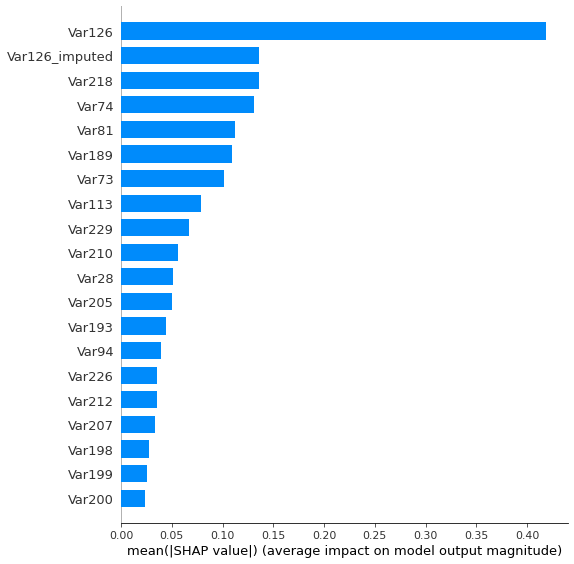

In [17]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

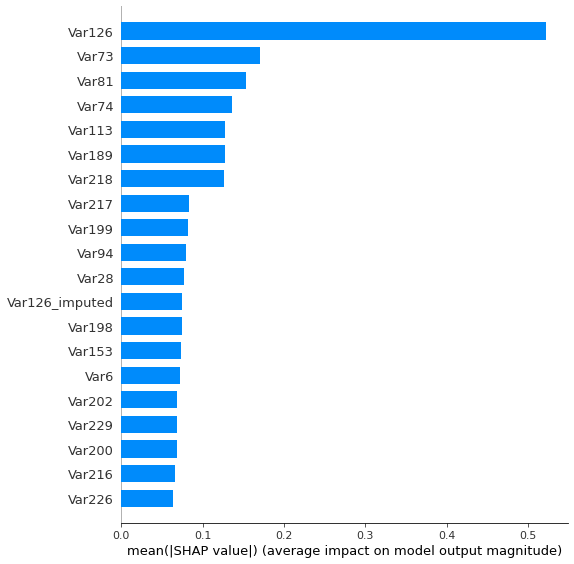

In [18]:
shap_values_paper = shap.TreeExplainer(model_xgb_paper).shap_values(train_X)
shap.summary_plot(shap_values_paper, train_X, plot_type="bar")

In [50]:
train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]

Index(['age', 'martial_status', 'relationship', 'capital_gain',
       'education_num', 'hours_per_week', 'fnlwgt', 'occupation',
       'capital_loss', 'sex', 'workclass', 'education', 'race',
       'native_country'],
      dtype='object')

In [19]:
df_compare = pd.DataFrame([train_X.columns[x[0]] for x in importance_lgbm], columns=["LightGBM"])
df_compare["LightGBM_Paper"] = [train_X.columns[x[0]] for x in importance_lgbm]
df_compare["XGBoost"] = [x[0] for x in importance_xgb] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb])) + [train_X.columns[-1]]
df_compare["XGBoost_Paper"] = [x[0] for x in importance_xgb_paper] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb_paper])) + [train_X.columns[-1]]
df_compare["SHAP_XGBoost"] = train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]
df_compare["SHAP_XGBoost_Paper"] = train_X.columns[np.argsort(np.abs(shap_values_paper).mean(0))][::-1]
df_compare["TabNet"] = [train_X.columns[x[0]] for x in importance_tabnet]
df_compare["TabNet_Paper"] = [train_X.columns[x[0]] for x in importance_tabnet_paper]

In [20]:
df_compare.head(10)

,LightGBM,LightGBM_Paper,XGBoost,XGBoost_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper
0,Var198,Var198,Var126,Var113,Var126,Var126,Var192,Var73
1,Var192,Var192,Var113,Var217,Var126_imputed,Var73,Var220,Var38
2,Var199,Var199,Var218,Var199,Var218,Var81,Var33,Var133
3,Var202,Var202,Var73,Var198,Var74,Var74,Var126_imputed,Var110
4,Var216,Var216,Var210,Var202,Var81,Var113,Var158,Var186
5,Var204,Var204,Var81,Var192,Var189,Var189,Var213,Var189_imputed
6,Var197,Var197,Var199,Var220,Var73,Var218,Var154,Var200
7,Var217,Var217,Var202,Var81,Var113,Var217,Var128,Var37_imputed
8,Var113,Var113,Var217,Var222,Var229,Var199,Var31,Var134_imputed
9,Var126,Var126,Var198,Var126,Var210,Var94,Var177_imputed,Var125_imputed


In [37]:
top3_feats = {}
top3_feats["xgboost"] = ["Var126", "Var113", "Var218"]
top3_feats["shap"] = ["Var126", "Var126_imputed", "Var218"]
top3_feats["tabnet"] = ["Var125_imputed", "Var189", "Var66_imputed"]

In [38]:
top10_feats = {}
top10_feats["xgboost"] = ["Var126", "Var113", "Var218", "Var73", "Var210", "Var81", "Var199", "Var202", "Var217", "Var198"]
top10_feats["shap"] = ["Var126", "Var126_imputed", "Var218", "Var74", "Var81", "Var189", "Var73", "Var113", "Var229", "Var210"]
top10_feats["tabnet"] = ["Var125_imputed", "Var189", "Var66_imputed", "Var228", "Var194", "Var130", "Var21_imputed", "Var13_imputed", "Var134_imputed", "Var111"]

In [27]:
top_3 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:2, col1]) & set(df_compare.loc[:2, col2])))
        top_3.append(d)
top_3_data = pd.DataFrame(top_3, columns=["Model1", "Model2", "Sim"])

In [28]:
pd.pivot_table(top_3_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,3,3,0,0,1,0,0,1
LightGBM_Paper,3,3,0,0,1,0,0,1
SHAP_XGBoost,0,0,3,1,0,0,2,0
SHAP_XGBoost_Paper,0,0,1,3,0,1,1,0
TabNet,1,1,0,0,3,0,0,0
TabNet_Paper,0,0,0,1,0,3,0,0
XGBoost,0,0,2,1,0,0,3,1
XGBoost_Paper,1,1,0,0,0,0,1,3


In [29]:
top_5 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:4, col1]) & set(df_compare.loc[:4, col2])))
        top_5.append(d)
top_5_data = pd.DataFrame(top_5, columns=["Model1", "Model2", "Sim"])
    

In [30]:
pd.pivot_table(top_5_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,5,5,0,0,1,0,0,3
LightGBM_Paper,5,5,0,0,1,0,0,3
SHAP_XGBoost,0,0,5,3,1,0,2,0
SHAP_XGBoost_Paper,0,0,3,5,0,1,3,1
TabNet,1,1,1,0,5,0,0,0
TabNet_Paper,0,0,0,1,0,5,1,0
XGBoost,0,0,2,3,0,1,5,1
XGBoost_Paper,3,3,0,1,0,0,1,5


In [34]:
top_10 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:9, col1]) & set(df_compare.loc[:9, col2])))
        top_10.append(d)
top_10_data = pd.DataFrame(top_10, columns=["Model1", "Model2", "Sim"])
    

In [35]:
pd.pivot_table(top_10_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,10,10,2,4,1,0,6,7
LightGBM_Paper,10,10,2,4,1,0,6,7
SHAP_XGBoost,2,2,10,7,1,1,6,3
SHAP_XGBoost_Paper,4,4,7,10,0,1,7,5
TabNet,1,1,1,0,10,0,0,2
TabNet_Paper,0,0,1,1,0,10,1,0
XGBoost,6,6,6,7,0,1,10,7
XGBoost_Paper,7,7,3,5,2,0,7,10


In [40]:
top3_results = []
for model, feats in top3_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([train_X.columns[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top3_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top3_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=50)
    top3_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top3_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

[20:47:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.33373 |  0:00:15s
epoch 1  | loss: 0.25581 |  0:00:31s
epoch 2  | loss: 0.25029 |  0:00:47s
epoch 3  | loss: 0.24989 |  0:01:04s
epoch 4  | loss: 0.24904 |  0:01:20s
epoch 5  | loss: 0.24948 |  0:01:35s
epoch 6  | loss: 0.24961 |  0:01:52s
epoch 7  | loss: 0.25    |  0:02:05s
epoch 8  | loss: 0.24765 |  0:02:20s
epoch 9  | loss: 0.24764 |  0:02:33s
epoch 10 | loss: 0.24648 |  0:02:46s
epoch 11 | loss: 0.24722 |  0:03:01s
epoch 12 | loss: 0.2476  |  0:03:14s
epoch 13 | loss: 0.2478  |  0:03:27s
epoch 14 | loss: 0.24779 |  0:03:42

In [41]:
top_3_scores = pd.DataFrame(top3_results, columns=["Features", "Model", "Score", "Value"])

In [42]:
pd.pivot_table(top_3_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.928010  0.680010  0.927876  0.675720
tabnet    0.928010  0.608055  0.928010  0.604741
xgboost   0.927743  0.678791  0.928276  0.688417

In [43]:
top10_results = []
for model, feats in top10_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([train_X.columns[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top10_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top10_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=50)
    top10_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top10_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

[21:45:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.3079  |  0:00:18s
epoch 1  | loss: 0.25974 |  0:00:32s
epoch 2  | loss: 0.25422 |  0:00:48s
epoch 3  | loss: 0.25107 |  0:01:13s
epoch 4  | loss: 0.25094 |  0:01:38s
epoch 5  | loss: 0.25067 |  0:02:01s
epoch 6  | loss: 0.24888 |  0:02:25s
epoch 7  | loss: 0.24717 |  0:02:49s
epoch 8  | loss: 0.24708 |  0:03:10s
epoch 9  | loss: 0.24799 |  0:03:35s
epoch 10 | loss: 0.24727 |  0:04:03s
epoch 11 | loss: 0.24783 |  0:04:26s
epoch 12 | loss: 0.24535 |  0:04:40s
epoch 13 | loss: 0.24455 |  0:04:59s
epoch 14 | loss: 0.24256 |  0:05:22

In [44]:
top_10_scores = pd.DataFrame(top10_results, columns=["Features", "Model", "Score", "Value"])

In [45]:
pd.pivot_table(top_10_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.928276  0.723319  0.928943  0.738180
tabnet    0.928010  0.633242  0.928010  0.638750
xgboost   0.891614  0.608121  0.928410  0.733035